In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.24:54313 Dashboard: http://10.148.1.24:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB


_________
# Read dataset


In [5]:
Nf = 4
data_dir = '/home1/scratch/xyu/mit_nc_t/'

filenames_Eta = sorted(glob(data_dir+'Eta_*.nc'))
filenames_Eta = filenames_Eta[:Nf]
ds_Eta = xr.open_mfdataset(filenames_Eta, concat_dim='time', compat='equals')

filenames_SSU = sorted(glob(data_dir+'SSU_*.nc'))
filenames_SSU = filenames_SSU[:Nf]
ds_SSU = xr.open_mfdataset(filenames_SSU, concat_dim='time', compat='equals')

filenames_SSV = sorted(glob(data_dir+'SSV_*.nc'))
filenames_SSV = filenames_SSV[:Nf]
ds_SSV = xr.open_mfdataset(filenames_SSV, concat_dim='time', compat='equals')

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=True)


In [6]:
ds = xr.merge([ds_Eta, ds_SSU, ds_SSV, grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 4)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    dtime    (time) datetime64[ns] dask.array<shape=(4,), chunksize=(1,)>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, j, i) float32 ...
    rAz      (face, j_g, i_g) float32 ...
    dxC      (face, j, i_

---


# 1. Time derivative of SSU ($G_u$)

A central difference is applied to compute du/dt.

In [7]:
d_SSU_dt_time1 = (ds['SSU'].isel(time=2) - ds['SSU'].isel(time=0))/2/3600
print(d_SSU_dt_time1)

<xarray.DataArray 'SSU' (face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4320, 4320)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (face, j, i_g) float32 478.96072 478.9889 479.01703 479.0451 ...
    dxC      (face, j, i_g) float32 324.6357 324.63788 324.64 324.64215 ...
    rAw      (face, j, i_g) float32 155487.83 155497.98 155508.08 155518.31 ...


In [8]:
d_SSU_dt_time1_face1 = d_SSU_dt_time1.isel(face=1)
print(d_SSU_dt_time1_face1)

<xarray.DataArray 'SSU' (j: 4320, i_g: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (j, i_g) float32 1230.9597 1230.9597 1230.9597 1230.9597 ...
    dxC      (j, i_g) float32 1261.4568 1261.4568 1261.4568 1261.4568 ...
    rAw      (j, i_g) float32 1552802.6 1552802.5 1552802.6 1552802.5 ...


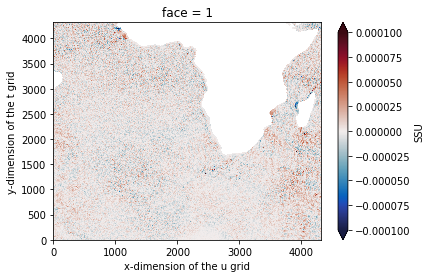

In [9]:
d_SSU_dt_time1_face1.load().plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

_______

# 2. Linear Coriolis terms ($G_u^{fv}$)

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [10]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [11]:
dxgSSV_j = grid.interp(ds.dxG * ds['SSV'],'Y')
print(dxgSSV_j)

<xarray.DataArray 'mul-02c4f34b5e0702be616c941612f54d34' (face: 13, j: 4320, i: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 4319, 4320, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [12]:
dxgSSV_ji = grid.interp(dxgSSV_j,'X')
print(dxgSSV_ji)

<xarray.DataArray 'mul-76e63c211737c4cb5e82e012c31910a8' (face: 13, j: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 4319, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [13]:
dxgSSV_ji_time1 = dxgSSV_ji.isel(time=1)
print(dxgSSV_ji_time1)

<xarray.DataArray 'mul-76e63c211737c4cb5e82e012c31910a8' (face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4319, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    time     float64 5.706e+06


### 2.1 Coriolis term f

In [14]:
lat = ds['YG']
print(lat)

<xarray.DataArray 'YG' (face: 13, j_g: 4320, i_g: 4320)>
[242611200 values with dtype=float32]
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    rAz      (face, j_g, i_g) float32 ...
Attributes:
    standard_name:  latitude_at_f_location
    long_name:      latitude
    units:          degrees_north


In [15]:
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))

In [16]:
f_j = grid.interp(f,'Y')
print(f_j)

<xarray.DataArray (face: 13, j: 4320, i_g: 4320)>
array([[[-1.459260e-04, -1.459262e-04, ..., -1.439605e-04, -1.439600e-04],
        [-1.459260e-04, -1.459262e-04, ..., -1.439605e-04, -1.439600e-04],
        ...,
        [-1.224780e-04, -1.224780e-04, ..., -1.224780e-04, -1.224780e-04],
        [-1.341982e-04, -1.341983e-04, ..., -1.332154e-04, -1.332152e-04]],

       [[-1.224473e-04, -1.224473e-04, ..., -1.224473e-04, -1.224473e-04],
        [-1.224320e-04, -1.224320e-04, ..., -1.224320e-04, -1.224320e-04],
        ...,
        [ 3.460194e-05,  3.460194e-05, ...,  3.460194e-05,  3.460194e-05],
        [-4.391500e-05, -4.391500e-05, ..., -4.391500e-05, -4.391500e-05]],

       ...,

       [[ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        ...,
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e

In [17]:
Coriolis_u = f_j * dxgSSV_ji_time1 /ds.dxC
print(Coriolis_u)

<xarray.DataArray (face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4319, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    time     float64 5.706e+06
    dyG      (face, j, i_g) float32 ...
    dxC      (face, j, i_g) float32 ...
    rAw      (face, j, i_g) float32 ...


In [18]:
Coriolis_u_time1_face1 = Coriolis_u.isel(face=1)
print(Coriolis_u_time1_face1)

<xarray.DataArray (j: 4320, i_g: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(4319, 1)>
Coordinates:
    face     int64 1
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    time     float64 5.706e+06
    dyG      (j, i_g) float32 ...
    dxC      (j, i_g) float32 ...
    rAw      (j, i_g) float32 ...


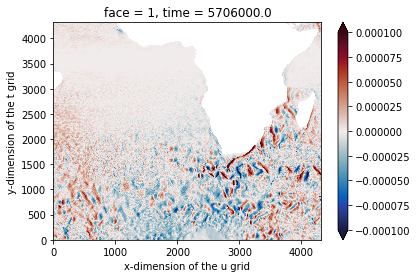

In [19]:
Coriolis_u_time1_face1.load().plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 3. Non-linear Coriolis terms ($G_u^{\zeta v}$)

Here we compute the vertical component of the vorticity from the velocity field. It is defined as

$$ \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

On the c-grid, a finite-volume representation is given by

$$ \zeta =  (- \delta_j \Delta x_c u + \delta_i \Delta y_c v ) / A_\zeta \ . $$

In xgcm, we calculate this quanity at (i_g, j_g)

In [21]:
zeta_3 = (grid.diff(ds.dyC * ds['SSV'],'X') - grid.diff(ds.dxC * ds['SSU'],'Y'))/ds.rAz
print(zeta_3)

<xarray.DataArray (face: 13, j_g: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 -88.17569 -88.17861 -88.181526 ...
    rAz      (face, j_g, i_g) float32 ...


In [22]:
Coriolis_zeta3_u = grid.interp(zeta_3,'Y') * dxgSSV_ji /ds.dxC
print(Coriolis_zeta3_u)

<xarray.DataArray (face: 13, j: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    dyG      (face, j, i_g) float32 ...
    dxC      (face, j, i_g) float32 ...
    rAw      (face, j, i_g) float32 ...


In [23]:
Coriolis_zeta3_u_time1_face1 = Coriolis_zeta3_u.isel(face=1,time=1)

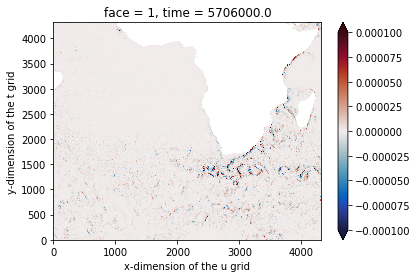

In [24]:
Coriolis_zeta3_u_time1_face1.load().plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 4. Gradient of Bernoulli function ($G_u^{\partial_x B}$)

### 4.1 face connections (Creating the grid object)

In [53]:
face_connections = {'face': {0: {'X': ((12, 'Y', False), (3, 'X', False)),
                                 'Y': (None, (1, 'Y', False))},
                             1: {'X': ((11, 'Y', False), (4, 'X', False)),
                                 'Y': ((0, 'Y', False), (2, 'Y', False))},
                             2: {'X': ((10, 'Y', False), (5, 'X', False)),
                                 'Y': ((1, 'Y', False), (6, 'X', False))},
                             3: {'X': ((0, 'X', False), (9, 'Y', False)),
                                 'Y': (None, (4, 'Y', False))},
                             4: {'X': ((1, 'X', False), (8, 'Y', False)),
                                 'Y': ((3, 'Y', False), (5, 'Y', False))},
                             5: {'X': ((2, 'X', False), (7, 'Y', False)),
                                 'Y': ((4, 'Y', False), (6, 'Y', False))},
                             6: {'X': ((2, 'Y', False), (7, 'X', False)),
                                 'Y': ((5, 'Y', False), (10, 'X', False))},
                             7: {'X': ((6, 'X', False), (8, 'X', False)),
                                 'Y': ((5, 'X', False), (10, 'Y', False))},
                             8: {'X': ((7, 'X', False), (9, 'X', False)),
                                 'Y': ((4, 'X', False), (11, 'Y', False))},
                             9: {'X': ((8, 'X', False), None),
                                 'Y': ((3, 'X', False), (12, 'Y', False))},
                             10: {'X': ((6, 'Y', False), (11, 'X', False)),
                                  'Y': ((7, 'Y', False), (2, 'X', False))},
                             11: {'X': ((10, 'X', False), (12, 'X', False)),
                                  'Y': ((8, 'Y', False), (1, 'X', False))},
                             12: {'X': ((11, 'X', False), None),
                                  'Y': ((9, 'Y', False), (0, 'X', False))}}}

In [26]:
x_grid = xgcm.Grid(ds, face_connections=face_connections)
print(x_grid)

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center


# 4.2 Gradient of 'pressure' (i.e. dphi/dx)

In [29]:
g = 9.81
dphi_dx = (x_grid.diff(g*ds['Eta'],'X'))/ds.dxC
print(dphi_dx)

<xarray.DataArray (time: 4, face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4320, 1)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (face, j, i_g) float32 ...
    dxC      (face, j, i_g) float32 ...
    rAw      (face, j, i_g) float32 ...


In [30]:
dphi_dx_time1_face1 = dphi_dx.isel(time=1,face=1)
print(dphi_dx_time1_face1)

<xarray.DataArray (j: 4320, i_g: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(4320, 1)>
Coordinates:
    time     float64 5.706e+06
    face     int64 1
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (j, i_g) float32 ...
    dxC      (j, i_g) float32 ...
    rAw      (j, i_g) float32 ...


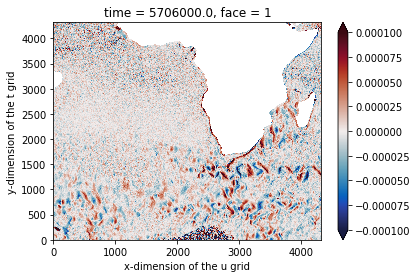

In [31]:
dphi_dx_time1_face1.load().plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 4.3 Gradient of KE
Finally, we calculate the kinetic energy $1/2 (u^2 + v^2)$ by interpolating both quantities into the cell center point (i.e. (i, j)).

In [32]:
KE = (grid.interp(ds['SSU']**2,'X') + grid.interp(ds['SSV']**2,'Y'))/2
print(KE)

<xarray.DataArray (time: 4, face: 13, j: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4319, 4319)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [33]:
dKE_dx = (x_grid.diff(KE,'X'))/ds.dxC
print(dKE_dx)

<xarray.DataArray (time: 4, face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 1, 1)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (face, j, i_g) float32 ...
    dxC      (face, j, i_g) float32 ...
    rAw      (face, j, i_g) float32 ...


In [34]:
dKE_dx_time1_face1 = dKE_dx.isel(time=1,face=1)
print(dKE_dx_time1_face1)

<xarray.DataArray (j: 4320, i_g: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 1)>
Coordinates:
    time     float64 5.706e+06
    face     int64 1
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (j, i_g) float32 ...
    dxC      (j, i_g) float32 ...
    rAw      (j, i_g) float32 ...


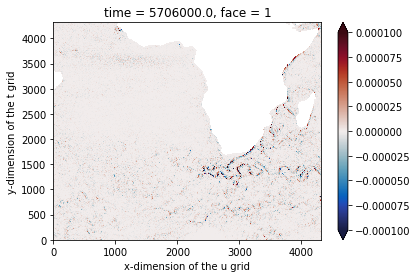

In [44]:
dKE_dx_time1_face1.load().plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 5. Residuals

residuals_u = du/dt - coriolis_linear - coriolis_nonliear +  gradient_of_Bernoulli_function

In [45]:
residuals_u_time1_face1 = (d_SSU_dt_time1_face1 - Coriolis_u_time1_face1 - Coriolis_zeta3_u_time1_face1 + dphi_dx_time1_face1 + dKE_dx_time1_face1).load()
print(residuals_u_time1_face1)

<xarray.DataArray (j: 4320, i_g: 4320)>
array([[-4.682123e-05, -6.651268e-06, -3.951905e-06, ...,  2.187978e-06,
        -3.777020e-06, -3.316979e-06],
       [-2.702266e-05, -2.455462e-06,  2.214001e-07, ..., -7.654360e-06,
        -9.213400e-06, -7.661220e-06],
       [-2.383411e-05, -5.574107e-07,  6.954251e-07, ..., -9.760027e-06,
        -9.900076e-06, -7.163012e-06],
       ...,
       [ 6.377213e-06,  5.935360e-06, -2.643942e-06, ...,  3.640639e-07,
         1.340107e-06, -1.417717e-06],
       [ 5.040946e-06,  4.927212e-06, -8.021071e-06, ...,  1.158799e-06,
         2.019761e-06, -1.768969e-06],
       [-2.075241e-05, -7.391729e-06,  1.495201e-06, ...,  1.554073e-06,
        -6.107636e-06, -1.333186e-05]], dtype=float32)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (j, i_g) float32 1230.9597 1230.9597 1230.9597 1230.95

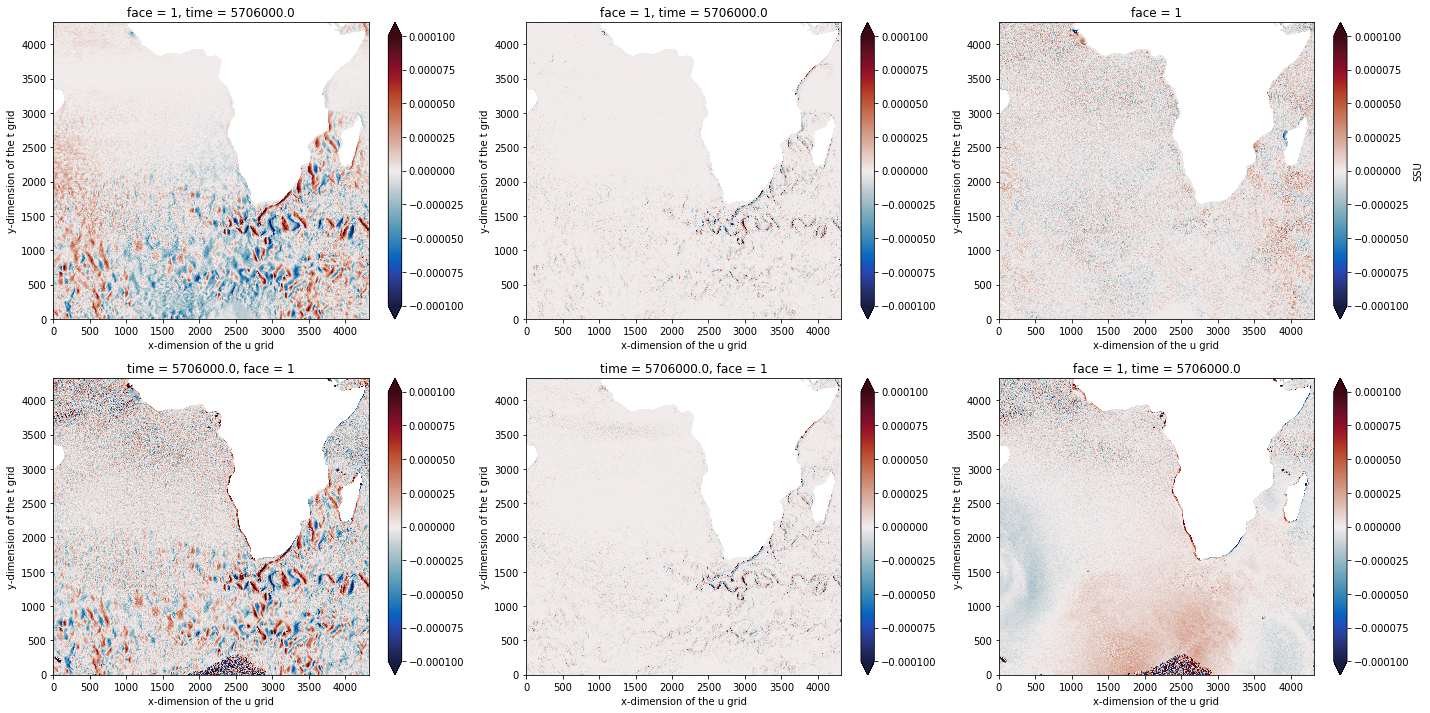

In [37]:
fig = plt.figure(figsize = (24,12))

plt.subplot(231)
Coriolis_u_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(234)
dphi_dx_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(232)
Coriolis_zeta3_u_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(235)
dKE_dx_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(233)
d_SSU_dt_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(236)
residuals_u_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

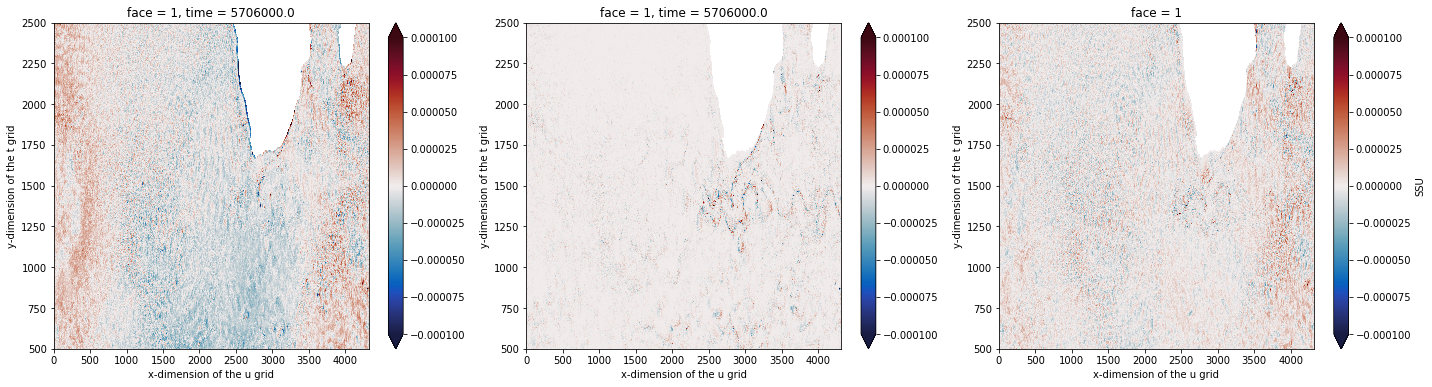

In [54]:
fig = plt.figure(figsize = (24,6))

plt.subplot(131)
(Coriolis_u_time1_face1-dphi_dx_time1_face1).isel(j=slice(500,2500)).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(132)
(Coriolis_zeta3_u_time1_face1-dKE_dx_time1_face1).isel(j=slice(500,2500)).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(133)
d_SSU_dt_time1_face1.isel(j=slice(500,2500)).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)


In [56]:
cluster.scheduler.close()

<Future finished result=None>